# Itroduction:
The objective of this notebook is to test the image classification method proposed in the fastai deep learning course (lesson 1) on a different image set from kaggle.
The plant seedlings classification competition is [hosted on Kaggle](https://www.kaggle.com/c/plant-seedlings-classification)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [97]:
import os
import shutil
import glob
import random
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

from fastai import conv_learner as cv
from fastai import plots as pl

# Data Preparation:

The data is downloaded in the folder stored in PATH:

In [3]:
PATH = './kaggle/competitions/plant-seedlings-classification/'

In [4]:
!ls {PATH}

csv_train   sample_submission.csv      test.zip  train.zip
labels.csv  sample_submission.csv.zip  tmp
models	    test		       train


In [5]:
!ls {PATH}train -la

total 216
drwxrwxr-x 14 root root  4096 Nov 21  2017 .
drwxr-xr-x  7 root root  4096 Jul 15 14:27 ..
drwxrwxr-x  2 root root 12288 Nov 21  2017 Black-grass
drwxrwxr-x  2 root root 20480 Nov 21  2017 Charlock
drwxrwxr-x  2 root root 12288 Nov 21  2017 Cleavers
drwxrwxr-x  2 root root 24576 Nov 21  2017 Common Chickweed
drwxrwxr-x  2 root root 12288 Nov 21  2017 Common wheat
drwxrwxr-x  2 root root 20480 Nov 21  2017 Fat Hen
drwxrwxr-x  2 root root 24576 Nov 21  2017 Loose Silky-bent
drwxrwxr-x  2 root root 12288 Nov 21  2017 Maize
drwxrwxr-x  2 root root 20480 Nov 21  2017 Scentless Mayweed
drwxrwxr-x  2 root root 12288 Nov 21  2017 Shepherds Purse
drwxrwxr-x  2 root root 20480 Nov 21  2017 Small-flowered Cranesbill
drwxrwxr-x  2 root root 20480 Nov 21  2017 Sugar beet


In [6]:
!ls {PATH}train/Black-grass

0050f38b3.png  355cad34c.png  6a19547c5.png  a26cb8017.png  d0ad9c78b.png
0183fdf68.png  37d85d833.png  6aabdeb45.png  a37d61200.png  d112c9c28.png
0260cffa8.png  39e9bf4c7.png  6afa7c717.png  a47cfeec4.png  d3c72d4c3.png
05eedce4d.png  3a8c485bc.png  6b9ebf8cc.png  a53088ca0.png  d3e69adad.png
075d004bc.png  3b7266ac3.png  6e027ec7d.png  a5f23b59f.png  d3ff1a639.png
078eae073.png  3b7d1fe82.png  6e193f1bb.png  a6f939a8b.png  d441eeda3.png
082314602.png  3dc08a0f7.png  7050b0b8a.png  a7d2b005e.png  d6036a0f4.png
0ace21089.png  3de7650a2.png  70bfa70ff.png  a87fd277c.png  d622ca3d2.png
0b228a6b8.png  3e9ef1999.png  71f6e3227.png  a8ab1ff26.png  d8afd58f3.png
0b3e7a7a9.png  3f268bcf8.png  72fd52505.png  a8cdae28a.png  da4f48653.png
0bb75ded8.png  3fb361e79.png  75ef53b3b.png  a8de8a80a.png  da5082ce2.png
0be707615.png  3ff68fa8a.png  765a69082.png  aa5bb06a1.png  daa7d4620.png
0c67c3fc3.png  40bf7be90.png  775735fb9.png  ab479d343.png  db337c4e7.png
0d1a9985f.png  418808d19.png  77629b9e

In [7]:
!ls {PATH}test

0021e90e4.png  33748968f.png  65e97117e.png  98d819587.png  cb496f36e.png
003d61042.png  338c7e907.png  664194d19.png  98da6ef4e.png  cb76a7766.png
007b3da8b.png  34dd57ca9.png  6680836dd.png  99036c51d.png  cbba27d89.png
0086a6340.png  3526b05cc.png  668c1007c.png  99569b224.png  cbe761896.png
00c47e980.png  35a90f8d0.png  66ab0e8d0.png  995c7ab1e.png  cc3d2a59a.png
00d090cde.png  35cf9fa01.png  675ec1b0b.png  9a3f20121.png  cc74feadc.png
00ef713a8.png  35ebe165c.png  67ce3eaa6.png  9aa5587fe.png  cd5f0db1c.png
01291174f.png  36839d5e9.png  67e185673.png  9b4800b42.png  cd6adba97.png
026716f9b.png  36d62bf36.png  686dc7ec8.png  9b9911f20.png  ce15eee52.png
02cfeb38d.png  36ed4f215.png  6908fb540.png  9baf94467.png  ce3d280eb.png
03566743d.png  37297a64c.png  6982a9d30.png  9c0c5b731.png  ce42adffb.png
03a2ee656.png  37714071b.png  699d3c707.png  9c32a797e.png  cec5bf198.png
03e322a29.png  377283a21.png  69d1669f8.png  9c777333d.png  cf3a8b2fd.png
03ef36742.png  37c3108d6.png  6a41bf95

## Validation Set Strategy:
We see that all the training data is stored in folders per category. We need to slit each data set in training and validation set.
Let's create a CSV file and use the csv interface for managing model data.

In [8]:
paths = glob.glob(f'{PATH}train/*/*.png', recursive=True)
files = [path.split('/train/')[1]  for path in paths]
files

['Scentless Mayweed/66d94aa80.png',
 'Scentless Mayweed/e4f5d3cf6.png',
 'Scentless Mayweed/a7ee2d8a4.png',
 'Scentless Mayweed/5186c72ca.png',
 'Scentless Mayweed/0a2bcaf43.png',
 'Scentless Mayweed/e850905dd.png',
 'Scentless Mayweed/b0885ca26.png',
 'Scentless Mayweed/03906fdd7.png',
 'Scentless Mayweed/38ddbde70.png',
 'Scentless Mayweed/bbd2ce539.png',
 'Scentless Mayweed/d48058bb8.png',
 'Scentless Mayweed/ddb46795d.png',
 'Scentless Mayweed/37573d77c.png',
 'Scentless Mayweed/a029e78bb.png',
 'Scentless Mayweed/0919cf5f1.png',
 'Scentless Mayweed/991bc45af.png',
 'Scentless Mayweed/88b1699ea.png',
 'Scentless Mayweed/086894274.png',
 'Scentless Mayweed/8bf8cb21a.png',
 'Scentless Mayweed/2e2bb8089.png',
 'Scentless Mayweed/3a64d0130.png',
 'Scentless Mayweed/acd879423.png',
 'Scentless Mayweed/a29a89017.png',
 'Scentless Mayweed/425efb679.png',
 'Scentless Mayweed/bc656f071.png',
 'Scentless Mayweed/9524b09c2.png',
 'Scentless Mayweed/66b33c098.png',
 'Scentless Mayweed/f616c683

In [9]:
os.path.join(PATH, files[0])

'./kaggle/competitions/plant-seedlings-classification/Scentless Mayweed/66d94aa80.png'

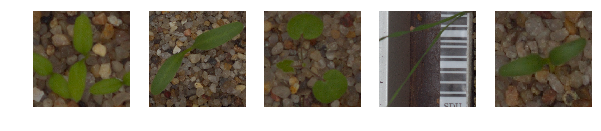

In [10]:
nb_records = len(files)
sample_indexes = [random.randint(0, nb_records-1) for _ in range(5)]
sample_pictures = [paths[index] for index in sample_indexes]
pl.plots_from_files(sample_pictures)

In [11]:
classes = [file.split('/')[0] for file in files]
classes = [cls.replace(" ", "_") for cls in classes]
classes

['Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentless_Mayweed',
 'Scentles

In [12]:
names = [file.split('/')[1] for file in files]
labels_df = pd.DataFrame({
    'image_name': names,
    'tags': classes,
})
labels_df

,image_name,tags
0,66d94aa80.png,Scentless_Mayweed
1,e4f5d3cf6.png,Scentless_Mayweed
2,a7ee2d8a4.png,Scentless_Mayweed
3,5186c72ca.png,Scentless_Mayweed
4,0a2bcaf43.png,Scentless_Mayweed
5,e850905dd.png,Scentless_Mayweed
6,b0885ca26.png,Scentless_Mayweed
7,03906fdd7.png,Scentless_Mayweed
8,38ddbde70.png,Scentless_Mayweed
9,bbd2ce539.png,Scentless_Mayweed


In [13]:
label_csv = f'{PATH}labels.csv'
labels_df.to_csv(label_csv, index=False)

In [14]:
!head -n 3 {label_csv}

image_name,tags
66d94aa80.png,Scentless_Mayweed
e4f5d3cf6.png,Scentless_Mayweed


In [15]:
# !mkdir {PATH}csv_train

In [16]:
# target = f'{PATH}csv_train'
# [shutil.copy2(path, target) for path in paths]

In [17]:
!ls -l {PATH}

total 1766692
drwxr-xr-x  2 root root     192512 Jul 15 14:29 csv_train
-rw-r--r--  1 root root     135384 Jul 15 17:03 labels.csv
drwxr-xr-x  2 root root       4096 Jul 15 11:49 models
-rw-rw-r--  1 root root      19863 Nov 21  2017 sample_submission.csv
-rw-r--r--  1 root root       5251 Jul 14 19:30 sample_submission.csv.zip
drwxrwxr-x  2 root root      36864 Nov 21  2017 test
-rw-r--r--  1 root root   90141460 Jul 14 19:30 test.zip
drwxr-xr-x  2 root root       4096 Jul 15 11:49 tmp
drwxrwxr-x 14 root root       4096 Nov 21  2017 train
-rw-r--r--  1 root root 1718530069 Jul 14 19:32 train.zip


# Build the Model

We split the data between train and validation and build the data objects using a helper function:

In [18]:
model = cv.resnet34

In [19]:
val_idxs = cv.get_cv_idxs(nb_records)

In [20]:
def get_data(size):
    tfms = cv.tfms_from_model(model, size, aug_tfms=cv.transforms_top_down, max_zoom=1.1)
    return cv.ImageClassifierData.from_csv(PATH, 'csv_train', label_csv, bs=16, 
                                           val_idxs=val_idxs, tfms=tfms, test_name='test')

In [21]:
data = get_data(64)

In [22]:
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common_Chickweed',
 'Common_wheat',
 'Fat_Hen',
 'Loose_Silky-bent',
 'Maize',
 'Scentless_Mayweed',
 'Shepherds_Purse',
 'Small-flowered_Cranesbill',
 'Sugar_beet']

In [30]:
x, y = next(iter(data.val_dl))

In [33]:
size = 64
data = get_data(64)
learner = cv.ConvLearner.pretrained(model, data)

In [34]:
lrn = learner.lr_find()

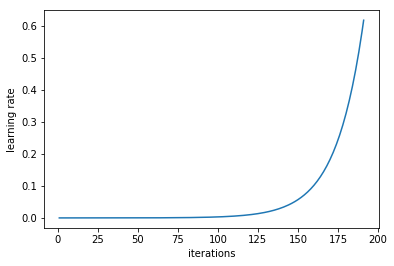

In [35]:
learner.sched.plot_lr()

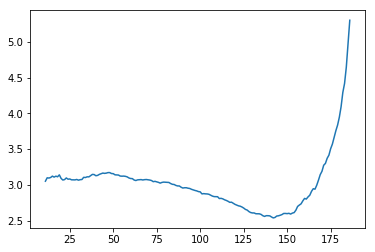

In [36]:
learner.sched.plot_loss()

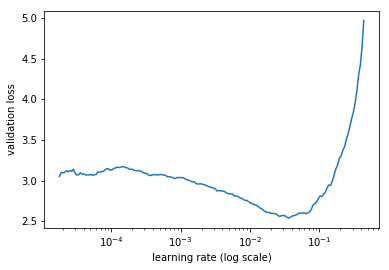

In [37]:
learner.sched.plot()

In [38]:
lr = 1e-2
learner.fit(lr, 1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.961938   1.657039   0.466316  


[array([1.65704]), 0.4663157895050551]

In [40]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.661997   1.295348   0.570526  
    1      1.684066   1.238532   0.565263                   
    2      1.47742    1.207939   0.581053                   
    3      1.549718   1.188553   0.590526                   
    4      1.47159    1.150523   0.604211                   
    5      1.427202   1.085507   0.64                       
    6      1.332228   1.080673   0.628421                   


[array([1.08067]), 0.628421052631579]

In [44]:
lrs = np.array([lr/9, lr/3, lr])
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.349764   1.095094   0.638947  
    1      1.429709   1.152714   0.604211                   
    2      1.324913   1.094013   0.626316                   
    3      1.422203   1.134179   0.606316                   
    4      1.375388   1.093645   0.625263                   
    5      1.321825   1.068391   0.634737                   
    6      1.279606   1.053577   0.650526                   


[array([1.05358]), 0.6505263159149571]

In [45]:
learner.unfreeze()
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.024935   0.642417   0.781053  
    1      0.847625   0.500265   0.838947                    
    2      0.637377   0.375446   0.867368                    
    3      0.686839   0.391443   0.858947                    
    4      0.519826   0.302084   0.895789                    
    5      0.426186   0.26362    0.906316                    
    6      0.38908    0.261723   0.906316                    


[array([0.26172]), 0.9063157894736842]

In [46]:
learner.save(f'{size}_image_size')

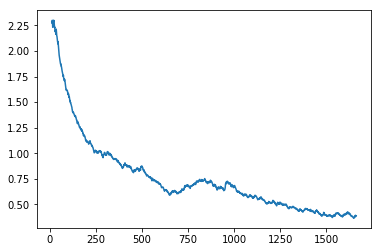

In [47]:
learner.sched.plot_loss()

In [48]:
size = 128
learner.set_data(get_data(size))

In [49]:
learner.freeze()
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.679935   0.468778   0.843158  
    1      0.601279   0.355639   0.875789                    
    2      0.498078   0.352027   0.88                        
    3      0.532248   0.347489   0.868421                    
    4      0.500361   0.302784   0.891579                    
    5      0.488886   0.299427   0.891579                    
    6      0.447086   0.289588   0.897895                    


[array([0.28959]), 0.8978947368421053]

In [50]:
learner.unfreeze()
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.507803   0.229148   0.92      
    1      0.446211   0.201841   0.922105                    
    2      0.343794   0.160196   0.931579                    
    3      0.392177   0.186438   0.931579                    
    4      0.298525   0.159666   0.937895                    
    5      0.227425   0.132205   0.949474                    
    6      0.195743   0.117308   0.956842                    


[array([0.11731]), 0.9568421052631579]

In [51]:
size = 256
learner.set_data(get_data(size))

In [52]:
learner.freeze()
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.446387   0.255475   0.924211  
    1      0.398063   0.213861   0.932632                    
    2      0.326586   0.19948    0.933684                    
    3      0.315863   0.193861   0.942105                    
    4      0.310276   0.170172   0.945263                    
    5      0.257557   0.167582   0.948421                    
    6      0.250568   0.163471   0.945263                    


[array([0.16347]), 0.9452631578947368]

In [53]:
learner.unfreeze()
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.281524   0.136757   0.949474  
    1      0.322874   0.11949    0.951579                    
    2      0.220317   0.094144   0.968421                    
    3      0.245725   0.122629   0.955789                    
    4      0.188892   0.095295   0.964211                    
    5      0.12344    0.088566   0.969474                    
    6      0.104914   0.077718   0.972632                     


[array([0.07772]), 0.9726315789473684]

In [54]:
learner.save(f'{size}_image_size')

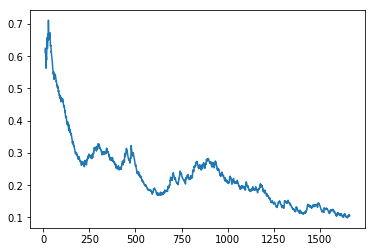

In [55]:
learner.sched.plot_loss()

In [56]:
size = 299
learner.set_data(get_data(size))

In [57]:
learner.freeze()
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.099118   0.076723   0.971579  
    1      0.101055   0.074521   0.971579                     
    2      0.092094   0.074573   0.972632                     
    3      0.080883   0.082681   0.968421                     
    4      0.086597   0.073494   0.970526                     
    5      0.076564   0.072941   0.972632                     
    6      0.084321   0.072486   0.970526                     


[array([0.07249]), 0.9705263157894737]

In [58]:
learner.unfreeze()
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.139175   0.080196   0.970526  
    1      0.207252   0.080817   0.974737                    
    2      0.13561    0.068327   0.976842                     
    3      0.156756   0.093179   0.966316                    
    4      0.145026   0.083695   0.965263                    
    5      0.102644   0.057356   0.98                         
    6      0.072461   0.055188   0.981053                     


[array([0.05519]), 0.9810526315789474]

In [59]:
learner.save(f'{size}_image_size')

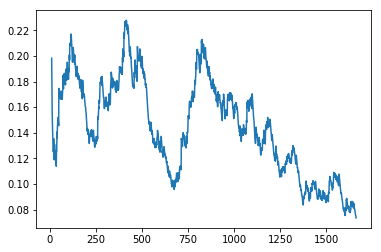

In [60]:
learner.sched.plot_loss()

In [91]:
log_preds, y = learner.TTA()

In [94]:
multi_probs = np.exp(log_preds)
probs = np.mean(multi_probs, 0)
probs

array([[0.     , 0.     , 0.     , ..., 0.00003, 0.     , 0.     ],
       [0.     , 0.00001, 0.00001, ..., 0.00097, 0.     , 0.00001],
       [0.     , 0.     , 0.00001, ..., 0.00002, 0.     , 0.00002],
       ...,
       [0.00004, 0.     , 0.00454, ..., 0.00001, 0.00002, 0.00176],
       [0.     , 0.00003, 0.     , ..., 0.00011, 0.     , 0.00001],
       [0.00001, 0.00004, 0.00772, ..., 0.00153, 0.00003, 0.01105]], dtype=float32)

In [96]:
predictions = [np.argmax(record) for record in probs]
predictions

[8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 1

In [99]:
confusion_mat = confusion_matrix(y, predictions)

[[ 38   0   0   0   3   0   5   0   0   0   0   0]
 [  0  68   0   0   0   0   0   0   0   0   0   0]
 [  0   0  53   0   0   0   0   0   0   0   0   0]
 [  0   0   0 133   0   0   0   0   1   0   0   0]
 [  0   0   0   0  41   0   0   0   0   0   0   0]
 [  0   0   0   0   0  78   0   0   0   0   0   0]
 [  3   0   0   0   0   0 137   0   0   0   0   0]
 [  0   0   0   0   0   0   0  43   0   0   0   0]
 [  0   0   0   0   0   0   0   0 117   0   0   0]
 [  0   0   0   0   0   0   0   0   1  51   0   0]
 [  0   0   0   0   0   0   0   0   0   0  97   0]
 [  0   1   0   0   0   0   0   0   0   0   0  80]]


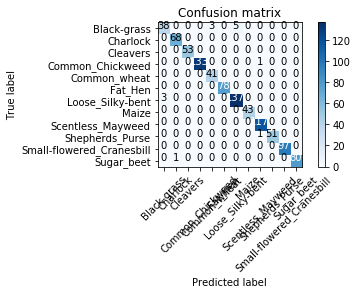

In [100]:
pl.plot_confusion_matrix(confusion_mat, data.classes)

In [103]:
true_classes = [data.classes[index].replace("_", " ") for index in y]
true_classes

['Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentles

In [104]:
predicted_classes = [data.classes[index].replace("_", " ") for index in predictions]
predicted_classes

['Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Scentles

In [105]:
validation_names = data.val_ds.fnames
validation_results_df = pd.DataFrame({
    'file': validation_names,
    'true_classes': true_classes,
    'predicted_classes': predicted_classes
})
validation_results_df.head()

,file,true_classes,predicted_classes
0,csv_train/38ddbde70.png,Scentless Mayweed,Scentless Mayweed
1,csv_train/37573d77c.png,Scentless Mayweed,Scentless Mayweed
2,csv_train/086894274.png,Scentless Mayweed,Scentless Mayweed
3,csv_train/2e2bb8089.png,Scentless Mayweed,Scentless Mayweed
4,csv_train/425efb679.png,Scentless Mayweed,Scentless Mayweed


# Make Prediction:

In [61]:
log_preds, y = learner.TTA(is_test=True)

In [67]:
multi_probs = np.exp(log_preds)
probs = np.mean(multi_probs, 0)
probs.shape

(794, 12)

In [68]:
probs

array([[0.00001, 0.00001, 0.00107, ..., 0.00269, 0.00003, 0.00018],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.00001],
       [0.     , 0.     , 0.00002, ..., 0.     , 0.99996, 0.     ],
       ...,
       [0.     , 0.99999, 0.     , ..., 0.     , 0.     , 0.     ],
       [0.00009, 0.00056, 0.00007, ..., 0.     , 0.     , 0.00009],
       [0.01497, 0.     , 0.00001, ..., 0.     , 0.00004, 0.00002]], dtype=float32)

In [72]:
predictions = [np.argmax(record) for record in probs]

In [77]:
class_predictions = [data.classes[index].replace("_", " ") for index in predictions]
class_predictions

['Common Chickweed',
 'Maize',
 'Small-flowered Cranesbill',
 'Loose Silky-bent',
 'Sugar beet',
 'Cleavers',
 'Common wheat',
 'Sugar beet',
 'Loose Silky-bent',
 'Fat Hen',
 'Common Chickweed',
 'Loose Silky-bent',
 'Charlock',
 'Small-flowered Cranesbill',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Fat Hen',
 'Loose Silky-bent',
 'Fat Hen',
 'Cleavers',
 'Scentless Mayweed',
 'Cleavers',
 'Cleavers',
 'Shepherds Purse',
 'Fat Hen',
 'Common Chickweed',
 'Common Chickweed',
 'Sugar beet',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Maize',
 'Maize',
 'Loose Silky-bent',
 'Small-flowered Cranesbill',
 'Fat Hen',
 'Charlock',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Sugar beet',
 'Small-flowered Cranesbill',
 'Shepherds Purse',
 'Charlock',
 'Fat Hen',
 'Loose Silky-bent',
 'Common wheat',
 'Charlock',
 'Scentless Mayweed',
 'Charlock',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Loose Silky-bent',
 'Charlock',
 'Black-grass',
 'Common wheat',
 'Cleavers',
 'Fat Hen',
 'Common 

In [78]:
test_names = data.test_ds.fnames
test_names

['test/756dd5070.png',
 'test/8170d33c1.png',
 'test/599691cd9.png',
 'test/cb496f36e.png',
 'test/0751c0bbc.png',
 'test/948cdb277.png',
 'test/8455169fe.png',
 'test/a8b431a3e.png',
 'test/0c27cf05f.png',
 'test/41f1c3cdb.png',
 'test/3827436f3.png',
 'test/3d38a87bc.png',
 'test/7a38416be.png',
 'test/1e095a7e1.png',
 'test/cf3a8b2fd.png',
 'test/da231c97f.png',
 'test/d563be369.png',
 'test/721be0a4a.png',
 'test/1d321253f.png',
 'test/a1e0a6c02.png',
 'test/c0bc3997b.png',
 'test/6bce55e05.png',
 'test/1be0713da.png',
 'test/6d6eb3830.png',
 'test/1623fb9e1.png',
 'test/98062cd87.png',
 'test/8e4eaeec0.png',
 'test/6b9d6f8c9.png',
 'test/46c14fde2.png',
 'test/0885e7690.png',
 'test/cbba27d89.png',
 'test/b4c3df835.png',
 'test/9c8b08a24.png',
 'test/d14aa43f3.png',
 'test/b7a7f6390.png',
 'test/f445fe6fb.png',
 'test/c5e419015.png',
 'test/c7b07431e.png',
 'test/8faadb6a8.png',
 'test/5f04aed97.png',
 'test/37c3108d6.png',
 'test/728eabae1.png',
 'test/86f08e6d1.png',
 'test/c6c8

In [79]:
pd.read_csv(f'{PATH}sample_submission.csv')

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet
5,00d090cde.png,Sugar beet
6,00ef713a8.png,Sugar beet
7,01291174f.png,Sugar beet
8,026716f9b.png,Sugar beet
9,02cfeb38d.png,Sugar beet


In [80]:
test_image_names = [name[5:] for name in test_names]

In [81]:
test_image_names

['756dd5070.png',
 '8170d33c1.png',
 '599691cd9.png',
 'cb496f36e.png',
 '0751c0bbc.png',
 '948cdb277.png',
 '8455169fe.png',
 'a8b431a3e.png',
 '0c27cf05f.png',
 '41f1c3cdb.png',
 '3827436f3.png',
 '3d38a87bc.png',
 '7a38416be.png',
 '1e095a7e1.png',
 'cf3a8b2fd.png',
 'da231c97f.png',
 'd563be369.png',
 '721be0a4a.png',
 '1d321253f.png',
 'a1e0a6c02.png',
 'c0bc3997b.png',
 '6bce55e05.png',
 '1be0713da.png',
 '6d6eb3830.png',
 '1623fb9e1.png',
 '98062cd87.png',
 '8e4eaeec0.png',
 '6b9d6f8c9.png',
 '46c14fde2.png',
 '0885e7690.png',
 'cbba27d89.png',
 'b4c3df835.png',
 '9c8b08a24.png',
 'd14aa43f3.png',
 'b7a7f6390.png',
 'f445fe6fb.png',
 'c5e419015.png',
 'c7b07431e.png',
 '8faadb6a8.png',
 '5f04aed97.png',
 '37c3108d6.png',
 '728eabae1.png',
 '86f08e6d1.png',
 'c6c8d4ba0.png',
 '3edf5e9ef.png',
 '406ecb5c5.png',
 'edfdb4aeb.png',
 'a8da9c08d.png',
 '7d22abf91.png',
 '165681fd9.png',
 'b573b7a56.png',
 '590f5aea6.png',
 'a254d71f6.png',
 '88d8a4508.png',
 '258b1183c.png',
 '44447390

In [82]:
submission_df = pd.DataFrame({
    'file': test_image_names,
    'species': class_predictions
})
submission_df.head()

,file,species
0,756dd5070.png,Common Chickweed
1,8170d33c1.png,Maize
2,599691cd9.png,Small-flowered Cranesbill
3,cb496f36e.png,Loose Silky-bent
4,0751c0bbc.png,Sugar beet


In [83]:
!mkdir {PATH}/submissions

In [84]:
submission_df.to_csv(f'{PATH}/submissions/submission_1.gz', compression="gzip", index=False)

In [86]:
!ls {PATH}/submissions

submission_1.gz


In [90]:
cv.FileLink(f'{PATH}submissions/submission_1.gz')

/storage/DL_playground/kaggle/competitions/plant-seedlings-classification/submissions/submission_1.gz